In [ ]:
!pip install datasets -q

In [ ]:
import gc
import numpy as np

import torch
import torch.nn as nn
from transformers import get_scheduler
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.modeling_outputs import CausalLMOutput
from datasets import load_dataset

from huggingface_hub import login

In [ ]:
HF_TOKEN = ""
login(HF_TOKEN)

In [ ]:
# MODEL_NAME = "fxmarty/small-llama-testing"
MODEL_NAME = "meta-llama/Llama-3.2-1B"

In [ ]:
def collect_c4_activations(model, dataset, tokenizer, MAX_C4_SAMPLES, LAYER_IDX):
    print(f"Collecting {MAX_C4_SAMPLES} samples' activations from C4")

    upper_layer_trajectories = []

    device = 'cuda:0'
    model = model.to(device)
    model.eval()

    for i, sample in enumerate(dataset):
        # Tokenize the input text
        inputs = tokenizer(sample["text"], return_tensors="pt", truncation=True, max_length=512)
        input_ids = inputs["input_ids"].to(device)

        with torch.no_grad():
            # Pass input through the model to get hidden states
            outputs = model(input_ids, output_hidden_states=True)
            hidden_states = outputs.hidden_states

            # Get the upper layer's embeddings (last layer hidden states)
            upper_layer_embeds = hidden_states[LAYER_IDX].squeeze(0)  # Shape: (seq_len, hidden_dim)

            # Append token indices (trajectory) and corresponding embeddings
            upper_layer_trajectories.append((input_ids.squeeze(0).tolist(), upper_layer_embeds.cpu().numpy()))

        if i % 100 == 0:
            print(f"Processed {i+1} samples out of {len(dataset)}")

        if i >= MAX_C4_SAMPLES:
            break

    print(f"Collected {len(upper_layer_trajectories)} upper-layer trajectories.")

    upper_activations = np.concatenate(
        [traj[1] for traj in upper_layer_trajectories],
        axis=0
    )
    token_trajectories = np.concatenate([
        np.array(traj[0])
        for traj in upper_layer_trajectories
    ], axis=0)

    return upper_activations, token_trajectories


def preprocess_function_collector(examples, model, tokenizer, MAX_LENGTH=256):
    prompt_template = "{context}\nQuestion: {question}\nAnswer:"
    inputs = [
        prompt_template.format(context=c, question=q)
        for c, q in zip(examples["context"], examples["question"])
    ]

    answers = [answer['text'][0] for answer in examples["answers"]]

    model_inputs = tokenizer(inputs, max_length=MAX_LENGTH, truncation=True, padding="max_length", return_tensors="pt")
    labels = tokenizer(answers, max_length=MAX_LENGTH, truncation=True, padding="max_length", return_tensors="pt")["input_ids"]

    for key in model_inputs.keys():
        model_inputs[key] = model_inputs[key].to(model.device)
    labels = labels.to(model.device)

    model_inputs["labels"] = labels

    print('labels == -100 sum:', (model_inputs["labels"] == -100).sum())

    model_inputs["labels"] = F.pad(
        model_inputs["labels"],
        (0, model_inputs["input_ids"].size(1) - model_inputs["labels"].size(1)),
        value=-100
    )

    print('labels == -100 sum:', (model_inputs["labels"] == -100).sum())

    return model_inputs


def collect_squad_activations(model, squad_dataset, tokenizer, MAX_SQUAD_SAMPLES, LAYER_IDX, cut_pads=False):
    class SquadCollateClass():
        def __init__(self, model, tokenizer):
            self.model = model
            self.tokenizer = tokenizer

        def __call__(self, dataset_items):
            batch = {
                "context": [sample["context"] for sample in dataset_items],
                "question": [sample["question"] for sample in dataset_items],
                "answers": [sample["answers"] for sample in dataset_items],
            }
            model_inputs = preprocess_function_collector(batch, self.model, self.tokenizer)
            return model_inputs

    device = 'cuda:0'
    model = model.to(device)

    def collect_upper_layer_trajectories(model, dataloader, extend_with_labels=False, max_samples=1000, layer_idx=-1, cut_pads=False):
        upper_layer_trajectories = []
        upper_layer_trajectories_with_labels = []
        model.eval()

        for i, model_inputs in enumerate(dataloader):
            for k in model_inputs.keys():
                model_inputs[k] = model_inputs[k].to(device)

            labels_clean = model_inputs['labels'].clone()
            labels_clean = labels_clean[:, :128]
            if (labels_clean == -100).sum():
                labels_clean[labels_clean == -100] = tokenizer.pad_token_id
                print('replaced -100 with pad_token_id')

            input_ids_list = [model_inputs["input_ids"]]
            trajectories_list = [upper_layer_trajectories]
            if extend_with_labels:
                extended_input_ids = torch.cat([model_inputs["input_ids"], labels_clean], dim=1)
                input_ids_list.append(extended_input_ids)
                trajectories_list.append(upper_layer_trajectories_with_labels)

            with torch.no_grad():
                for input_ids, trajectories in zip(input_ids_list, trajectories_list):
                    outputs = model(input_ids=input_ids, output_hidden_states=True)
                    hidden_states = outputs.hidden_states

                    layer_embeds = hidden_states[layer_idx]

                    for idx in range(input_ids.size(0)):
                        if cut_pads:
                            nonpad_mask = input_ids[idx] != tokenizer.pad_token_id
                        else:
                            nonpad_mask = torch.ones_like(input_ids[idx], dtype=torch.bool)

                        tokens_input_ids = np.array([
                            x.detach().cpu().numpy()
                            for x in input_ids[idx][nonpad_mask]
                        ])
                        n_tokens = nonpad_mask.sum().item()
                        embeddings = layer_embeds[idx][nonpad_mask].detach().cpu().numpy()

                        # if cut_pads:
                            # print(f'N tokens: {n_tokens} / orig shape: {layer_embeds[idx].shape}')
                        trajectories.append((tokens_input_ids, embeddings))

            # Optional progress report
            if i % 50 == 0:
                processed = (i + 1) * input_ids.size(0)
                print(f"Processed {processed} samples out of {min(len(squad_dataset), max_samples)}")

            if (i + 1) * dataloader.batch_size >= max_samples:
                break

        print(f"Collected {len(upper_layer_trajectories)} upper-layer trajectories.")
        if extend_with_labels:
            return upper_layer_trajectories, upper_layer_trajectories_with_labels
        return upper_layer_trajectories

    squad_collate = SquadCollateClass(model, tokenizer)
    dataloader = DataLoader(squad_dataset, batch_size=2, shuffle=True, collate_fn=squad_collate)
    upper_layer_trajectories_squad, upper_layer_trajectories_with_labels_squad = collect_upper_layer_trajectories(
        model, dataloader, extend_with_labels=True, max_samples=MAX_SQUAD_SAMPLES, layer_idx=LAYER_IDX, cut_pads=cut_pads
    )

    # print('shapes:')

    # for i, traj in enumerate(upper_layer_trajectories_squad):
    #     print(traj[0].shape, traj[1].shape)
    #     if i == 10: break

    # print('with labels now:')

    # for i, traj in enumerate(upper_layer_trajectories_with_labels_squad):
    #     print(traj[0].shape, traj[1].shape)
    #     if i == 10: break

    token_trajectories_squad = np.concatenate([
        np.array(traj[0])
        for traj in upper_layer_trajectories_squad
    ], axis=0)

    # activations_squad = np.concatenate([traj[1][None, ...] for traj in upper_layer_trajectories_squad], axis=0)
    activations_squad = np.concatenate([traj[1] for traj in upper_layer_trajectories_squad], axis=0)

    token_trajectories_with_labels_squad = np.concatenate([
        np.array(traj[0])
        for traj in upper_layer_trajectories_with_labels_squad
    ], axis=0)
    # activations_with_labels_squad = np.concatenate([traj[1][None, ...] for traj in upper_layer_trajectories_with_labels_squad], axis=0)
    activations_with_labels_squad = np.concatenate([traj[1] for traj in upper_layer_trajectories_with_labels_squad], axis=0)


    token_trajectories_squad = token_trajectories_squad.reshape(-1, token_trajectories_squad.shape[-1])
    token_trajectories_with_labels_squad = token_trajectories_with_labels_squad.reshape(-1, token_trajectories_with_labels_squad.shape[-1])
    activations_squad = activations_squad.reshape(-1, activations_squad.shape[-1])
    activations_with_labels_squad = activations_with_labels_squad.reshape(-1, activations_with_labels_squad.shape[-1])

    return token_trajectories_squad, activations_squad, token_trajectories_with_labels_squad, activations_with_labels_squad

In [ ]:

def original_init(embedding_layer, mean=0.0, std_dev=0.02):
    # print(embedding_layer)
    nn.init.normal_(embedding_layer, mean=mean, std=std_dev)

def gaussian_fitted_init(embedding_layer, prev_embeddings, num_embeddings=None):
    if num_embeddings is None:
        num_embeddings = embedding_layer.num_embeddings

    mean_vector = torch.mean(prev_embeddings, axis=0).to(torch.float32)
    cov_matrix = torch.cov(prev_embeddings.T).to(torch.float32)
    cov_matrix = cov_matrix + 1e-6 * torch.eye(cov_matrix.size(0), device=cov_matrix.device)

    mvn = torch.distributions.MultivariateNormal(mean_vector, covariance_matrix=cov_matrix)

    with torch.no_grad():
        sampled_weights = mvn.sample((num_embeddings,))
        print("Before assignment:")
        print(embedding_layer)
        embedding_layer[:] = sampled_weights
        # embedding_layer.data.copy_(sampled_weights)
        print("After assignment:")
        print(embedding_layer)


In [ ]:
def sample_gaussian_fitted_exclusion(data, N_samples, Dim, cov_coeff=None, epsilon=1e-6):
    if cov_coeff is None:
        # x ^ (D / 2) = 2 -> (D / 2) * log(x) = log(2) -> x = exp((2 / D) * log(2))
        cov_coeff = np.exp((2 / Dim) * np.log(2))
        print(cov_coeff)

    data = torch.tensor(data, dtype=torch.float32)

    mean_vector = torch.mean(data, dim=0)
    std_vector = torch.std(data, dim=0) + epsilon
    normalized_data = (data - mean_vector) / std_vector

    cov_matrix = torch.cov(normalized_data.T)

    mvn = torch.distributions.MultivariateNormal(torch.zeros_like(mean_vector), covariance_matrix=cov_matrix)
    mvn_wide = torch.distributions.MultivariateNormal(torch.zeros_like(mean_vector), covariance_matrix=cov_coeff * cov_matrix)

    sampled_weights = []
    n_sampled = 0
    average_acceptance_prob = 0.
    with torch.no_grad():
        for _ in range(N_samples):
            while True:
                n_sampled += 1
                sample = mvn_wide.sample()

                log_prob = mvn.log_prob(sample)
                log_prob_wide = mvn_wide.log_prob(sample)
                accept_prob = torch.max(1 - torch.exp(log_prob - log_prob_wide), torch.zeros_like(log_prob))

                average_acceptance_prob += accept_prob.item()

                # print(log_prob, log_prob_wide, accept_prob, torch.rand(1).item())

                if torch.rand(1).item() < accept_prob:
                    sampled_weights.append(sample)
                    break

            if _ % 10 == 9:
                print(f"Accepted {_ + 1} out of {n_sampled} sampled / {N_samples}")
                print(f"Average acceptrance rate: {average_acceptance_prob / n_sampled}\n")

        sampled_weights = torch.stack(sampled_weights, dim=0)
        sampled_weights = sampled_weights * std_vector + mean_vector
        return sampled_weights


def gaussian_fitted_exclusion_init_(
        embedding_layer, prev_embeddings,
        num_embeddings=None, dim=None,
        cov_coeff=None, epsilon=1e-6
):
    if num_embeddings is None:
        num_embeddings = embedding_layer.num_embeddings
    if dim is None:
        dim = embedding_layer.embedding_dim

    with torch.no_grad():
        sampled_weights = sample_gaussian_fitted_exclusion(
            prev_embeddings,
            num_embeddings,
            dim,
            cov_coeff,
            epsilon
        )
        embedding_layer.weight = nn.Parameter(sampled_weights) # CHECK IF CORRECT !

In [ ]:
def interpolate_gaussians_fitted_init(
        embedding_layer,
        first_embeddings,
        second_embeddings,
        alpha=0.5, #  alpha * x1 + (1 - alpha) * x2
        num_embeddings=None
):
    if num_embeddings is None:
        num_embeddings = embedding_layer.num_embeddings

    first_mean = torch.mean(first_embeddings, axis=0).to(torch.float32)
    second_mean = torch.mean(second_embeddings, axis=0).to(torch.float32)

    first_cov = torch.cov(first_embeddings.T).to(torch.float32)
    second_cov = torch.cov(second_embeddings.T).to(torch.float32)

    first_cov = first_cov + 1e-6 * torch.eye(first_cov.size(0), device=first_cov.device)
    second_cov = second_cov + 1e-6 * torch.eye(second_cov.size(0), device=second_cov.device)

    first_mvn = torch.distributions.MultivariateNormal(first_mean, covariance_matrix=first_cov)
    second_mvn = torch.distributions.MultivariateNormal(second_mean, covariance_matrix=second_cov)

    with torch.no_grad():
        first_sampled_weights = first_mvn.sample((num_embeddings,))
        second_sampled_weights = second_mvn.sample((num_embeddings,))

        sampled_weights = alpha * first_sampled_weights + (1 - alpha) * second_sampled_weights

        print("Before assignment:")
        print(embedding_layer)
        embedding_layer[:] = sampled_weights
        # embedding_layer.data.copy_(sampled_weights)
        print("After assignment:")
        print(embedding_layer)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

import torch.nn.functional as F

def preprocess_function_prompt_tuning(examples, MAX_LENGTH=256, **kwargs):
    prompt_template = "{context}\nQuestion: {question}\nAnswer:"
    inputs = [
        prompt_template.format(context=c, question=q)
        for c, q in zip(examples["context"], examples["question"])
    ]
    answers = [answer['text'][0] for answer in examples["answers"]]

    # Tokenize inputs and labels
    model_inputs = tokenizer(inputs, max_length=MAX_LENGTH, truncation=True, padding="max_length", return_tensors="pt")
    labels = tokenizer(answers, max_length=128, truncation=True, padding="max_length", return_tensors="pt")['input_ids']
    # labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels

    for key in model_inputs.keys():
        model_inputs[key] = model_inputs[key].to(kwargs["device"])

    # print('labels == -100 sum:', (model_inputs["labels"] == -100).sum())

    model_inputs["labels"] = F.pad(
        model_inputs["labels"],
        (0, model_inputs["input_ids"].size(1) - model_inputs["labels"].size(1)),
        value=-100 # tokenizer.pad_token_id
    )

    # print('labels == -100 sum:', (model_inputs["labels"] == -100).sum())

    # for key in model_inputs.keys():
    #     # model_inputs[key] = model_inputs[key].to(model.device)
    #     print(key, model_inputs[key].shape)

    return model_inputs

def preprocess_v1(batch, *args, **kwargs):
    # Tokenize inputs first
    inputs = [
        "{context}\nQuestion: {question}\nAnswer:".format(context=c, question=q)
        for c, q in zip(batch["context"], batch["question"])
    ]

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    # Move inputs to the correct device
    model_inputs['input_ids'] = model_inputs['input_ids'].to(kwargs["device"])
    model_inputs['attention_mask'] = model_inputs['attention_mask'].to(kwargs["device"])

    # Tokenize answers
    answers = [answer['text'][0] for answer in batch["answers"]]
    model_inputs["labels"] = tokenizer(
        answers,
        max_length=128,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )['input_ids'].to(kwargs["device"])

    return model_inputs



class DeepPromptTunedModel(nn.Module):
    def __init__(
            self,
            base_model_name,
            num_virtual_tokens=20,
            num_layers=None,
            selected_layers=None, # always includes input_embeddings layer
            pad_token_id=-100
    ):
        super().__init__()
        # Load base model
        self.base_model = AutoModelForCausalLM.from_pretrained(base_model_name, token=HF_TOKEN)

        # Determine number of layers if not specified
        if num_layers is None:
            num_layers = len(self.base_model.model.layers)
        if selected_layers is None:
            selected_layers = list(range(num_layers))

        # Create virtual token parameters for each layer
        self.virtual_token_parameters = nn.ParameterDict({
            f"deep-prompt-embeddings-layer-{layer_idx}": nn.Parameter(
                torch.randn(num_virtual_tokens, self.base_model.config.hidden_size)
            )
            for layer_idx in selected_layers
        })

        self.num_virtual_tokens = num_virtual_tokens
        self.num_layers = num_layers
        self.selected_layers = selected_layers
        self.pad_token_id = pad_token_id
        self.device = self.base_model.device

        # Freeze base model parameters
        for parameter in self.base_model.parameters():
            parameter.requires_grad = False

        # Make virtual token parameters trainable
        for layer_name in self.virtual_token_parameters:
            self.virtual_token_parameters[layer_name].requires_grad = True

    def init_virtual_token_parameters(
            self,
            init_function=None,
            init_function_kwargs_dict=None
    ):
        """
        Initialize virtual token parameters

        Args:
            init_function: Initialization method
            init_function_kwargs_dict: Dict of dicts of init arguments pef layer_idx
        """
        if init_function is None:
            # Default to Xavier initialization
            init_function = torch.nn.init.xavier_uniform_

        for layer_idx in self.selected_layers:
            kwargs = init_function_kwargs_dict[layer_idx] if init_function_kwargs_dict is not None else {}
            layer_name = f"deep-prompt-embeddings-layer-{layer_idx}"
            layer_params = self.virtual_token_parameters[layer_name]
            init_function(layer_params, **kwargs)


    def add_virtual_embeddings(self, original_input_embeddings, layer_idx, concatenate=True):
        """
        Add virtual embeddings to input at each layer
        Returns:
            Modified input embeddings
        """
        batch_size = original_input_embeddings.size(0)

        layer_name = f"deep-prompt-embeddings-layer-{layer_idx}"
        layer_params = self.virtual_token_parameters[layer_name]

        # print(f'Adding virtual embeddings, layer_idx: {layer_idx}')
        # print(f'original input embeddings.shape: {original_input_embeddings.shape}')

        layer_virtual_embeddings = layer_params.unsqueeze(0).repeat(batch_size, 1, 1)

        # print(layer_virtual_embeddings.shape)
        if concatenate:
            layer_input_embeddings = torch.cat([layer_virtual_embeddings, original_input_embeddings], dim=1)
        else:
            layer_input_embeddings = original_input_embeddings.clone()
            L = self.num_virtual_tokens
            layer_input_embeddings[:, :L, :] = (layer_input_embeddings[:, :L, :] + layer_virtual_embeddings) / 2

        # print(f'expanded input embeddings.shape: {layer_input_embeddings.shape}')

        return layer_input_embeddings

    def add_virtual_attention_mask(self, attention_mask):
        """ Extends attention mask w.r.t virtual tokens positions """
        virtual_attention_mask = torch.ones(
            (attention_mask.size(0), self.num_virtual_tokens),
            dtype=torch.long
        ).to(attention_mask.device)

        extended_attention_mask = torch.cat([virtual_attention_mask, attention_mask], dim=1)

        # print(f'Adding virtual attention_mask, layer_idx: {layer_idx}')
        # print(f'original attention_mask.shape: {attention_mask.shape}')
        # print(f'expanded attention_mask.shape: {extended_attention_mask.shape}')

        return extended_attention_mask


    def pt_forward(self, batch, **kwargs):

        # for key in tokenized_batch.keys():
        #     tokenized_batch[key] = tokenized_batch[key].to(model.device)

        # print(tokenized_batch)
        input_embeddings = self.base_model.get_input_embeddings()(batch['input_ids'])

        # Add virtual tokens at each layer
        layer_input_embeddings = self.add_virtual_embeddings(input_embeddings, layer_idx=0, concatenate=True) # embedding layer

        attention_mask = batch['attention_mask']
        extended_attention_mask = self.add_virtual_attention_mask(batch['attention_mask'])
        # attention_mask = attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=torch.bool)
        # extended_attention_mask = extended_attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=torch.bool)


        # Prepare initial states
        hidden_states = layer_input_embeddings

        # Store intermediate outputs for potential use
        all_hidden_states = [hidden_states]

        # print(f'N_layers: {len(self.base_model.model.layers)}')

        # Custom forward pass through model layers
        for layer_idx, layer in enumerate(self.base_model.model.layers):
            # Prepare position ids for the expanded input
            position_ids = torch.arange(
                0, layer_input_embeddings.size(1),
                dtype=torch.long,
                device=layer_input_embeddings.device
            ).unsqueeze(0).repeat(layer_input_embeddings.size(0), 1)

            # Prepare causal mask for attention
            batch_size, seq_length = layer_input_embeddings.size(0), layer_input_embeddings.size(1)

            # causal_mask = torch.zeros(batch_size, 1, seq_length, seq_length, device=device)
            # for i in range(batch_size):
            #     real_seq_len = extended_attention_mask[i].sum().item()
            #     causal_mask[i, :real_seq_len, :real_seq_len] = 1.
            # causal_mask = torch.tril(torch.ones(batch_size, 1, seq_length, seq_length, device=device))
            # causal_mask[:, :, :self.num_virtual_tokens, :] = False


            # from modelling_llama.py L907
            cache_position = torch.arange(0, layer_input_embeddings.shape[1], device=self.device)
            position_ids = cache_position.unsqueeze(0)
            causal_mask = self.base_model.model._update_causal_mask(
                extended_attention_mask, layer_input_embeddings, cache_position, None, False
            )
            position_embeddings = self.base_model.model.rotary_emb(
                layer_input_embeddings, position_ids
            )

            hidden_states, = layer(
                layer_input_embeddings,
                attention_mask=causal_mask,
                position_ids=position_ids,
                past_key_value=None,
                output_attentions=False,
                use_cache=False,
                cache_position=cache_position,
                position_embeddings=position_embeddings,
            )

            # hidden_states, = layer(
            #     hidden_states=layer_input_embeddings,
            #     attention_mask=causal_mask,
            #     position_ids=position_ids
            # )
            all_hidden_states.append(hidden_states)

            # print(f"layer_idx: {layer_idx}, hidden_states: {hidden_states}")

            if layer_idx in self.selected_layers:
                layer_input_embeddings = hidden_states[:, self.num_virtual_tokens:, :]
                print(f"cut virtual tokens, layer_input_embeddings.shape: {layer_input_embeddings.shape}")
            else:
                layer_input_embeddings = hidden_states

            if layer_idx + 1 in self.selected_layers:
                layer_input_embeddings = self.add_virtual_embeddings(
                    layer_input_embeddings,
                    layer_idx=layer_idx + 1 # account for the next layer
                )
                print(f"appended new virtual tokens, layer_input_embeddings.shape: {layer_input_embeddings.shape}")

        # print('final hidden states.shape:', layer_input_embeddings.shape)
        # Final layer processing
        logits = self.base_model.lm_head(layer_input_embeddings)

        # Compute loss
        loss = None
        if batch['labels'] is not None:
            # Pad labels to match input embedding length
            # logits = logits[:, self.num_virtual_tokens:].contiguous()

            batch["labels"] = F.pad(
                batch["labels"],
                (0, logits.size(1) - batch["labels"].size(1)),
                value=-100
            )

            loss = self.base_model.loss_function(
                logits=logits,
                labels=batch['labels'],
                vocab_size=self.base_model.config.vocab_size
            )

        return CausalLMOutput(**{
            'loss': loss,
            'logits': logits,
            'hidden_states': all_hidden_states
        })

    def orig_forward(self, batch, **kwargs):
        return self.base_model(**batch, **kwargs)

    def forward(self, batch, **kwargs):
        return self.orig_forward(batch, **kwargs)

    def update_forward_to_pt(self):
        self.forward = self.pt_forward

    def update_forward_to_original(self):
        self.forward = self.orig_forward

    def to(self, device):
        self.base_model.to(device)
        for layer_idx, layer_params in self.virtual_token_parameters.items():
            self.virtual_token_parameters[layer_idx] = layer_params.to(device)
        self.device = device
        return self

In [ ]:
# base_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, token=HF_TOKEN)
# base_model.config.num_hidden_layers

In [ ]:
NUM_VIRTUAL_TOKENS = 20
NUM_HIDDEN_LAYERS = 16
SELECTED_LAYERS = [0, 13, 14, 15]

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)
tokenizer.pad_token_id = tokenizer.eos_token_id
print(tokenizer.pad_token_id)

# Example initialization

model = DeepPromptTunedModel(
    base_model_name=MODEL_NAME,
    num_virtual_tokens=NUM_VIRTUAL_TOKENS,  # Number of virtual tokens per layer
    num_layers=NUM_HIDDEN_LAYERS,
    selected_layers=SELECTED_LAYERS,
    pad_token_id=tokenizer.pad_token_id
).to('cuda')

# Initialize virtual token embeddings
# You can use custom initialization like before
vocab = list(tokenizer.get_vocab().keys())

128001


In [ ]:
# IMPORTANT !!

model.update_forward_to_pt()

In [ ]:
# Collect input embeddings
N = 20000
random_indices = np.random.choice(len(vocab), N, replace=False)
input_embeddings = model.base_model.get_input_embeddings().weight.detach().clone()[random_indices]

In [ ]:
# Collect model activations over the datasets

import os

def collect_selected_layers_activations(
        model, tokenizer,
        MAX_C4_SAMPLES, MAX_SQUAD_SAMPLES,
        selected_layers,
        save_activations,
        load_activations,
        load_paths={}
):
    if load_activations and len(load_paths) == 0:
        load_paths = {
            layer_idx : {
                "token_trajectories_c4": "activations/tokens_on_input_ids_c4.npy",
                "activations_c4": f"activations/activations_{layer_idx}_on_input_ids_c4.npy",
                "token_trajectories_squad": "activations/tokens_on_input_ids_squad.npy",
                "token_trajectories_with_labels_squad": "activations/tokens_on_input_ids_labels_squad.npy",
                "activations_squad": f"activations/activations_{layer_idx}_on_input_ids_squad.npy",
                "activations_with_labels_squad": f"activations/activations_{layer_idx}_on_input_ids_labels_squad.npy"
            }
            for layer_idx in selected_layers
        }

    path = "allenai/c4"
    name = None
    streaming = False
    split = "train"
    data_files = {"train": "en/c4-train.00000-of-01024.json.gz"}
    shuffle_seed = 52

    dataset = load_dataset(path, name=name, split=split, data_files=data_files)
    dataset = dataset.shuffle(shuffle_seed)
    dataset = dataset.select(range(MAX_C4_SAMPLES))

    squad_dataset = load_dataset("squad", split='train')
    squad_dataset = squad_dataset.shuffle(shuffle_seed)
    squad_dataset = squad_dataset.select(range(MAX_SQUAD_SAMPLES))

    res = {
        "activations_c4": {},
        "token_trajectories_c4": {},
        "activations_squad": {},
        "token_trajectories_squad": {},
        "token_trajectories_with_labels_squad": {},
        "activations_with_labels_squad": {}
    }

    for layer_idx in selected_layers:
        if load_activations:
            upper_activations = np.load(load_paths[layer_idx]["activations_c4"])
            token_trajectories = np.load(load_paths[layer_idx]["token_trajectories_c4"])
            token_trajectories_squad = np.load(load_paths[layer_idx]["token_trajectories_squad"])
            token_trajectories_with_labels_squad = np.load(load_paths[layer_idx]["token_trajectories_with_labels_squad"])
            activations_squad = np.load(load_paths[layer_idx]["activations_squad"])
            activations_with_labels_squad = np.load(load_paths[layer_idx]["activations_with_labels_squad"])
        else:
            upper_activations, token_trajectories = collect_c4_activations(
                model, dataset, tokenizer, MAX_C4_SAMPLES, layer_idx
            )
            output = collect_squad_activations(
                model, squad_dataset, tokenizer, MAX_SQUAD_SAMPLES, layer_idx, cut_pads=True
            )
            token_trajectories_squad, activations_squad, token_trajectories_with_labels_squad, activations_with_labels_squad = output

        if not os.path.exists("activations"):
            os.makedirs("activations")

        if (not load_activations) and save_activations:
            np.save(f'activations/tokens_on_input_ids_c4.npy', token_trajectories)
            np.save(f'activations/activations_{layer_idx}_on_input_ids_c4.npy', upper_activations)
            np.save(f'activations/tokens_on_input_ids_squad.npy', token_trajectories_squad)
            np.save(f'activations/tokens_on_input_ids_labels_squad.npy', token_trajectories_with_labels_squad)
            np.save(f'activations/activations_{layer_idx}_on_input_ids_squad.npy', activations_squad)
            np.save(f'activations/activations_{layer_idx}_on_input_ids_labels_squad.npy', activations_with_labels_squad)

        res["activations_c4"][layer_idx] = upper_activations
        res["activations_squad"][layer_idx] = activations_squad
        res["activations_with_labels_squad"][layer_idx] = activations_with_labels_squad

        res["token_trajectories_c4"][layer_idx] = token_trajectories
        res["token_trajectories_squad"][layer_idx] = token_trajectories_squad
        res["token_trajectories_with_labels_squad"][layer_idx] = token_trajectories_with_labels_squad

    return res

In [ ]:
# Collect model activations over the datasets

import os

def collect_selected_layers_activations_c4(
        model, tokenizer,
        MAX_C4_SAMPLES,
        selected_layers,
        save_activations,
        load_activations,
        load_paths={}
):
    if load_activations and len(load_paths) == 0:
        load_paths = {
            layer_idx : {
                "token_trajectories_c4": "activations/tokens_on_input_ids_c4.npy",
                "activations_c4": f"activations/activations_{layer_idx}_on_input_ids_c4.npy"
            }
            for layer_idx in selected_layers
        }

    path = "allenai/c4"
    name = None
    streaming = False
    split = "train"
    data_files = {"train": "en/c4-train.00000-of-01024.json.gz"}
    shuffle_seed = 52

    dataset = load_dataset(path, name=name, split=split, data_files=data_files)
    dataset = dataset.shuffle(shuffle_seed)
    dataset = dataset.select(range(MAX_C4_SAMPLES))

    res = {
        "activations_c4": {},
        "token_trajectories_c4": {}
    }

    for layer_idx in selected_layers:
        if load_activations:
            upper_activations = np.load(load_paths[layer_idx]["activations_c4"])
            token_trajectories = np.load(load_paths[layer_idx]["token_trajectories_c4"])
        else:
            upper_activations, token_trajectories = collect_c4_activations(
                model, dataset, tokenizer, MAX_C4_SAMPLES, layer_idx
            )

        if not os.path.exists("activations"):
            os.makedirs("activations")

        if (not load_activations) and save_activations:
            np.save(f'activations/tokens_on_input_ids_c4.npy', token_trajectories)
            np.save(f'activations/activations_{layer_idx}_on_input_ids_c4.npy', upper_activations)

        res["activations_c4"][layer_idx] = upper_activations
        res["token_trajectories_c4"][layer_idx] = token_trajectories

    return res

    # Collect model activations over the datasets

def collect_selected_layers_activations_squad(
        model, tokenizer,
        MAX_SQUAD_SAMPLES,
        selected_layers,
        save_activations,
        load_activations,
        load_paths={}
):
    if load_activations and len(load_paths) == 0:
        load_paths = {
            layer_idx : {
                "token_trajectories_squad": "activations/tokens_on_input_ids_squad.npy",
                "token_trajectories_with_labels_squad": "activations/tokens_on_input_ids_labels_squad.npy",
                "activations_squad": f"activations/activations_{layer_idx}_on_input_ids_squad.npy",
                "activations_with_labels_squad": f"activations/activations_{layer_idx}_on_input_ids_labels_squad.npy"
            }
            for layer_idx in selected_layers
        }

    shuffle_seed = 52
    squad_dataset = load_dataset("squad", split='train')
    squad_dataset = squad_dataset.shuffle(shuffle_seed)
    squad_dataset = squad_dataset.select(range(MAX_SQUAD_SAMPLES))

    res = {
        "activations_squad": {},
        "token_trajectories_squad": {},
        "token_trajectories_with_labels_squad": {},
        "activations_with_labels_squad": {}
    }

    for layer_idx in selected_layers:
        if load_activations:
            token_trajectories_squad = np.load(load_paths[layer_idx]["token_trajectories_squad"])
            token_trajectories_with_labels_squad = np.load(load_paths[layer_idx]["token_trajectories_with_labels_squad"])
            activations_squad = np.load(load_paths[layer_idx]["activations_squad"])
            activations_with_labels_squad = np.load(load_paths[layer_idx]["activations_with_labels_squad"])
        else:
            output = collect_squad_activations(
                model, squad_dataset, tokenizer, MAX_SQUAD_SAMPLES, layer_idx, cut_pads=True
            )
            token_trajectories_squad, activations_squad, token_trajectories_with_labels_squad, activations_with_labels_squad = output

        if not os.path.exists("activations"):
            os.makedirs("activations")

        if (not load_activations) and save_activations:
            np.save(f'activations/tokens_on_input_ids_squad.npy', token_trajectories_squad)
            np.save(f'activations/tokens_on_input_ids_labels_squad.npy', token_trajectories_with_labels_squad)
            np.save(f'activations/activations_{layer_idx}_on_input_ids_squad.npy', activations_squad)
            np.save(f'activations/activations_{layer_idx}_on_input_ids_labels_squad.npy', activations_with_labels_squad)

        res["activations_squad"][layer_idx] = activations_squad
        res["activations_with_labels_squad"][layer_idx] = activations_with_labels_squad

        res["token_trajectories_squad"][layer_idx] = token_trajectories_squad
        res["token_trajectories_with_labels_squad"][layer_idx] = token_trajectories_with_labels_squad

    return res

In [ ]:
# base_model = AutoModelForCausalLM.from_pretrained(model_name, token=HF_TOKEN)

In [ ]:
# from google.colab import drive
# import shutil
# import os

# # Mount Google Drive
# drive.mount('/content/drive')

In [ ]:
# shutil.copy('/content/xavier-embeddings-layer-0-only.npy', '/content/drive/My Drive/BML_project_data')

In [ ]:
# # MOVE FROM GOOGLE DRIVE

# source_filename = 'llama_pt_activations_last4.zip'
# gdrive_path = '/content/drive/My Drive/BML_project_data/'  # Directory in Google Drive
# destination_dir = '/content'  # Destination directory in Colab

# # Move the file
# source_file = os.path.join(gdrive_path, source_filename)
# destination_file = os.path.join(destination_dir, source_filename)
# shutil.copy(source_file, destination_file)

# print(f"{source_filename} has been moved to {destination_file}")

In [ ]:
# !unzip /content/llama_pt_activations_100.zip -d /content/

In [ ]:
# !mv activations/ activations_pads/

In [ ]:
model.update_forward_to_original()
ALL_activations = collect_selected_layers_activations(
    model.base_model, tokenizer,
    MAX_C4_SAMPLES=250,
    MAX_SQUAD_SAMPLES=250,
    selected_layers=SELECTED_LAYERS,
    save_activations=True,
    load_activations=False
)

# ALL_activations = collect_selected_layers_activations_squad(
#     model.base_model, tokenizer,
#     MAX_SQUAD_SAMPLES=100,
#     selected_layers=SELECTED_LAYERS,
#     save_activations=False,
#     load_activations=False
# )
model.update_forward_to_pt()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processed 1 samples out of 250
Processed 101 samples out of 250
Processed 201 samples out of 250
Collected 250 upper-layer trajectories.
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
Processed 2 samples out of 250
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, device='cuda:0')
labels == -100 sum: tensor(0, dev

In [ ]:
!zip -r llama_pt_activations_last3.zip activations/ # <-- 3.3 Gb for 100 samples each, 6 min

  adding: activations/ (stored 0%)
  adding: activations/activations_13_on_input_ids_labels_squad.npy (deflated 7%)
  adding: activations/activations_0_on_input_ids_squad.npy (deflated 54%)
  adding: activations/tokens_on_input_ids_labels_squad.npy (deflated 75%)
  adding: activations/activations_14_on_input_ids_labels_squad.npy (deflated 7%)
  adding: activations/tokens_on_input_ids_squad.npy (deflated 75%)
  adding: activations/activations_14_on_input_ids_c4.npy (deflated 7%)
  adding: activations/activations_15_on_input_ids_squad.npy (deflated 7%)
  adding: activations/tokens_on_input_ids_c4.npy (deflated 75%)
  adding: activations/activations_15_on_input_ids_labels_squad.npy (deflated 7%)
  adding: activations/activations_13_on_input_ids_c4.npy (deflated 7%)
  adding: activations/activations_0_on_input_ids_c4.npy (deflated 54%)
  adding: activations/activations_14_on_input_ids_squad.npy (deflated 7%)
  adding: activations/activations_0_on_input_ids_labels_squad.npy (deflated 54%)
 

In [ ]:
# # MOVE TO GOOGLE DRIVE

# # Define paths
# source_file = '/content/llama_pt_activations_last4.zip'  # Path to activations.zip in Colab
# destination_dir = '/content/drive/My Drive/BML_project_data'  # Directory in Google Drive

# # Create the destination directory if it doesn't exist
# os.makedirs(destination_dir, exist_ok=True)

# # Move the file
# destination_file = os.path.join(destination_dir, 'llama_pt_activations_last3.zip')
# shutil.move(source_file, destination_file)

# print(f"activations.zip has been moved to {destination_file}")


In [ ]:
# IF WE ARE RE-COMPUTING THE ACTIVATIONS, WE DON'T NEED THIS ANYMORE
# THOUGH IT SHOULD BE SAFE
for key in ALL_activations.keys():
    if 'squad' in key:
        for layer_idx in ALL_activations[key].keys():
            ALL_activations[key][layer_idx] = ALL_activations[key][layer_idx].reshape(-1, ALL_activations[key][layer_idx].shape[-1])

In [ ]:
# ALL_activations['activations_squad'][0].shape

In [ ]:
ALL_activations_torch = {
    key: {
        layer_idx: torch.from_numpy(value)
        for layer_idx, value in layer_values.items()
    }
    for key, layer_values in ALL_activations.items()
}

In [ ]:
# len(model.virtual_token_parameters)

In [ ]:
# model.virtual_token_parameters.keys()

In [ ]:
# input_embeddings.shape

In [ ]:
# ALL_activations_torch['activations_squad'][0].shape

In [ ]:
interpolate_gaussians_fitted_init

<function __main__.interpolate_gaussians_fitted_init(embedding_layer, first_embeddings, second_embeddings, alpha=0.5, num_embeddings=None)>

In [ ]:
init_function_kwargs_dict = {
    layer_idx: {
        "first_embeddings": ALL_activations_torch['activations_c4'][layer_idx],
        "second_embeddings": ALL_activations_torch['activations_squad'][layer_idx],
        "alpha": 0.5,
        "num_embeddings": model.num_virtual_tokens
    }
    for layer_idx in SELECTED_LAYERS
}
# init_function_kwargs_dict[0] = {
#     "prev_embeddings": input_embeddings,
#     "num_embeddings": model.num_virtual_tokens
# }

model.init_virtual_token_parameters(
    # init_function=None,
    # init_function=original_init
    # init_function=gaussian_fitted_init,
    init_function=interpolate_gaussians_fitted_init,
    init_function_kwargs_dict=init_function_kwargs_dict
)

Before assignment:
Parameter containing:
tensor([[ 1.7770, -0.8989, -1.5592,  ..., -0.2648, -0.2368,  2.4661],
        [ 0.9893,  1.9144, -0.2001,  ...,  0.9695, -0.9337,  2.0297],
        [ 0.1792,  1.3584,  0.8943,  ...,  1.2338, -0.1385,  0.3223],
        ...,
        [ 0.1462,  0.3967,  1.7139,  ..., -0.6731, -1.1287, -2.1498],
        [ 1.5243,  1.9549,  0.4205,  ..., -0.5145,  0.2852, -0.0816],
        [-0.4170, -1.1796,  0.0972,  ...,  1.4251,  0.6828, -0.6326]],
       device='cuda:0', requires_grad=True)
After assignment:
Parameter containing:
tensor([[-0.0031,  0.0023,  0.0017,  ..., -0.0125,  0.0196, -0.0035],
        [-0.0072,  0.0542,  0.0179,  ...,  0.0092,  0.0078,  0.0022],
        [-0.0114, -0.0163,  0.0204,  ..., -0.0001, -0.0091,  0.0079],
        ...,
        [-0.0065,  0.0055,  0.0110,  ...,  0.0057,  0.0012,  0.0165],
        [ 0.0043,  0.0107, -0.0065,  ..., -0.0320,  0.0008, -0.0201],
        [ 0.0129,  0.0009,  0.0163,  ..., -0.0130, -0.0172, -0.0135]],
       

In [ ]:
trainable_params = 0
total_params = 0

for name, parameter in model.named_parameters():
    if parameter.requires_grad:
        print(f"Trainable Parameter: {name}")
        trainable_params += 1
    total_params += 1

print(f"Trainable Params: {(trainable_params / total_params) * 100:.3f}%")

Trainable Parameter: virtual_token_parameters.deep-prompt-embeddings-layer-0
Trainable Parameter: virtual_token_parameters.deep-prompt-embeddings-layer-13
Trainable Parameter: virtual_token_parameters.deep-prompt-embeddings-layer-14
Trainable Parameter: virtual_token_parameters.deep-prompt-embeddings-layer-15
Trainable Params: 2.667%


In [ ]:
class PromptTuningCollateClass():
    def __init__(self, preproces_function, preprocess_function_kwargs):
        self.preprocess_function = preproces_function
        self.preprocess_function_kwargs = preprocess_function_kwargs

    def __call__(self, batch):
        batch = {
            "context": [item["context"] for item in batch],
            "question": [item["question"] for item in batch],
            "answers": [item["answers"] for item in batch]
        }
        return self.preprocess_function(batch, **self.preprocess_function_kwargs)

In [ ]:
def custom_forward(model, input_embeddings, attention_mask, labels=None):
    outputs = model(
        inputs_embeds=input_embeddings,
        attention_mask=attention_mask,
        labels=labels,
    )
    return outputs

In [ ]:
def get_grad_norm(model, norm_type=2):
    parameters = model.parameters()
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]

    for param in parameters:
        print(torch.norm(param.grad.detach(), norm_type).item())

    total_norm = torch.norm(
        torch.stack(
            [torch.norm(p.grad.detach(), norm_type).cpu() for p in parameters]
        ),
        norm_type,
    )
    return total_norm.item()

In [ ]:
from itertools import repeat

def inf_loop(data_loader):
    """wrapper function for endless data loader."""
    for loader in repeat(data_loader):
        yield from loader

In [ ]:
# Preprocess data function (assuming you have a preprocess function defined)
# train_dataset = dataset["train"].map(preprocess_function, batched=True)
# val_dataset = dataset["validation"].map(preprocess_function, batched=True)
# Load SQuAD dataset as an example

from torch.utils.data import Dataset

class SQUADDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length, max_samples=None):
        super().__init__()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.max_samples = max_samples
        self.dataset = self.process(dataset)

    def tokenize(self, sample):
        prompt_template = "{context}\nQuestion: {question}\nAnswer:"
        inputs = prompt_template.format(context=sample['context'], question=sample['question'])
        input_ids = tokenizer(inputs, truncation=True, return_tensors="pt")['input_ids']
        return input_ids

    def process(self, base_dataset):
        dataset = []
        print(f"Processing base dataset of length {len(base_dataset)}...")
        sample_indices = np.random.choice(len(base_dataset), len(base_dataset), replace=False)

        for idx in sample_indices:
            sample = base_dataset[int(idx)]
            input_ids = self.tokenize(sample)
            if input_ids.shape[1] > self.max_length:
                continue
            dataset.append(sample)
            if self.max_samples is not None and len(dataset) >= self.max_samples:
                break

        print(f"Processed, left {len(dataset)} samples!")
        return dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

dataset = load_dataset("squad")


MAX_LENGTH = 256
MAX_TRAIN_SAMPLES = 1000
MAX_VAL_SAMPLES = 1000

base_train_dataset = dataset['train']
base_val_dataset = dataset['validation']

train_dataset = SQUADDataset(base_train_dataset, tokenizer, MAX_LENGTH, MAX_TRAIN_SAMPLES)
val_dataset = SQUADDataset(base_val_dataset, tokenizer, MAX_LENGTH, MAX_VAL_SAMPLES)

collate = PromptTuningCollateClass(
    preproces_function=preprocess_function_prompt_tuning,
    preprocess_function_kwargs={
        "device":'cuda',
        "MAX_LENGTH": MAX_LENGTH
    }
)

BATCH_SIZE = 4

# Using smaller batch sizes for memory efficiency
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False, collate_fn=collate)
train_loader = inf_loop(train_loader)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=False, collate_fn=collate)
val_loader = inf_loop(val_loader)

# Training loop
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Enable mixed precision training for better memory usage (if using a compatible GPU)
# scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
scaler = None

Processing base dataset of length 87599...
Processed, left 1000 samples!
Processing base dataset of length 10570...
Processed, left 1000 samples!


In [ ]:
import wandb

import os
os.environ['WANDB_API_KEY'] = "96b7c9ce4fa58a9b8254a7e3b14ef24071ecd75e"
os.environ["WANDB_MODE"] = "online"

In [ ]:
wandb.finish()

In [ ]:
model.forward

<bound method DeepPromptTunedModel.pt_forward of DeepPromptTunedModel(
  (base_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 2048)
      (layers): ModuleList(
        (0-15): 16 x LlamaDecoderLayer(
          (self_attn): LlamaSdpaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=512, bias=False)
            (v_proj): Linear(in_features=2048, out_features=512, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
          (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        )
      )
      (norm): LlamaRMSNorm((2048,), eps=1e-05)
      (rotary_emb): LlamaRotaryEmbedding()
    )
    (lm_head): Linear(in_features=2048, out_features=128256, bias=False)
  )
  (virtual_token_parameters): ParameterDict(
      (deep-prompt-embeddings-layer-0): Parameter containing: [torch.cuda.FloatTensor of size 20x2048 (cuda:0)]
      (deep-prompt-embeddings-layer-13): Parameter containing: [torch.cuda.FloatTensor of size 20x2048 (cuda:0)]
      (deep-prompt-embeddings-layer-14): Parameter containing: [torch.cuda.FloatTensor of size 20x2048 (cuda:0)]
      (deep-prompt-embeddings-layer-15): Parameter containing: [torch.cuda.FloatTensor of size 20x2048 (cuda:0)]
  )
)>

In [ ]:
from tqdm.notebook import tqdm

N_EPOCHS = 100
LEN_EPOCH = 25
LEN_VAL_EPOCH = 25
N_BATCHES_ACCUMULATED = 1

BASELINE_BATCH_SIZE = 2
BATCH_SIZE_COEFF = BATCH_SIZE / BASELINE_BATCH_SIZE # for correct wandb steps

LR = 1e-3
BETAS = (0.9, 0.8)
WEIGHT_DECAY = 1e-5

optimizer = torch.optim.AdamW(
    list(model.virtual_token_parameters.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    betas=BETAS
)
num_training_steps = int(LEN_EPOCH / N_BATCHES_ACCUMULATED * N_EPOCHS)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=0
)

wandb.init(
    project="bayesian-prompt-tuning",
    entity="nomoreactimel",
    name="[gaussian-deep] Paper Params Deep-PT-0-13-14-15 Gaussian Sampling",
    config={
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "weight_decay": WEIGHT_DECAY,
        "betas": BETAS,
        "grad_accumulation": N_BATCHES_ACCUMULATED,
        "epochs": N_EPOCHS,
        "len_epoch": LEN_EPOCH,
        "len_val_epoch": LEN_VAL_EPOCH
    }
)

wandb.watch(model, log=None, log_freq=10)



for epoch in range(N_EPOCHS):

    def epoch_train():
        model.train()
        optimizer.zero_grad()

        epoch_train_loss = 0
        accumulation_steps = 0

        for step, batch in tqdm(enumerate(train_loader), total=LEN_EPOCH):
            if scaler and False:
                with torch.cuda.amp.autocast():
                    outputs = model(batch)
                    loss = outputs.loss
            else:
                outputs = model(batch)
                loss = outputs.loss

            loss = loss / N_BATCHES_ACCUMULATED
            epoch_train_loss += loss.item()

            if scaler and False:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            if (step + 1) % N_BATCHES_ACCUMULATED == 0 or (step + 1) == LEN_EPOCH:
                if scaler and False:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()

                lr_scheduler.step()

                accumulation_steps += 1

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_train_loss / accumulation_steps,
                    "learning_rate": optimizer.param_groups[0]['lr'],
                    "grad_norm": get_grad_norm(model)
                }, step = int(BATCH_SIZE_COEFF * (step + 1 + epoch * LEN_EPOCH)))

                optimizer.zero_grad()

            if step >= LEN_EPOCH - 1:
                break

        return step, epoch_train_loss

    def epoch_val(step):
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader):
                outputs = model(batch)
                val_loss = outputs.loss
                epoch_val_loss += val_loss.item()

                if val_step >= LEN_VAL_EPOCH - 1:
                    break

            wandb.log({
                "epoch": epoch + 1,
                "val_loss": epoch_val_loss / LEN_VAL_EPOCH,
            }, step = int(BATCH_SIZE_COEFF * (step + 1 + epoch * LEN_EPOCH)))

            print(f"Epoch {epoch+1}, Validation Loss: {epoch_val_loss / LEN_VAL_EPOCH}")

        return epoch_val_loss

    if epoch == 0:
        epoch_val(0)

    step, epoch_train_loss = epoch_train()
    epoch_val_loss = epoch_val(step)

    wandb.log({
        "epoch": epoch + 1,
        "epoch_train_loss": epoch_train_loss / LEN_EPOCH * N_BATCHES_ACCUMULATED,
        "epoch_val_loss": epoch_val_loss / LEN_VAL_EPOCH
    }, step = int(BATCH_SIZE_COEFF * (step + 1 + epoch * LEN_EPOCH)))


    # Clear CUDA cache to reduce memory fragmentation after each epoch
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Finish the wandb run
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nomoreactimel. Use `wandb login --relogin` to force relogin


cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, la

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
11.106236457824707
0.10996890813112259
0.13650208711624146
0.046523258090019226
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_in

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
4.718111515045166
0.12816418707370758
0.36724382638931274
0.04168195277452469
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_inpu

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
6.9495062828063965
0.11993859708309174
0.17791485786437988
0.02405330166220665
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_inp

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
3.5623550415039062
0.0871184840798378
0.20617324113845825
0.01563018001616001
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_inpu

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
2.200878620147705
0.03875166177749634
0.03886754438281059
0.006623333785682917
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_inp

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.5274301767349243
0.017856447026133537
0.015179906971752644
0.0032553428318351507
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.4375483989715576
0.010121097788214684
0.00905721727758646
0.002946498105302453
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.2344425469636917
0.006581658031791449
0.005778250750154257
0.0027247313410043716
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.28851139545440674
0.011505596339702606
0.008798510767519474
0.0035444926470518112
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, laye

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.6237806081771851
0.03278563544154167
0.03366410359740257
0.008273533545434475
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_in

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.3669697046279907
0.02800309844315052
0.02761499583721161
0.00810507033020258
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_inp

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.19451938569545746
0.0187718216329813
0.019352246075868607
0.00602420000359416
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_in

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.2087038904428482
0.018436281010508537
0.01906578615307808
0.006650097668170929
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.1709064245223999
0.019322121515870094
0.01823567971587181
0.005978936329483986
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.1881202757358551
0.01356416754424572
0.01304593775421381
0.005293173249810934
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_in

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.11772723495960236
0.012624460272490978
0.0139781404286623
0.004906661808490753
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.28937187790870667
0.01994667761027813
0.019816208630800247
0.007310914341360331
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.12729798257350922
0.009331517852842808
0.007372631691396236
0.0034416194539517164
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, laye

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.13017652928829193
0.014893068931996822
0.0162255447357893
0.0051355608738958836
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.27680784463882446
0.034460388123989105
0.03477362543344498
0.010631978511810303
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.1661892831325531
0.020555736497044563
0.020887112244963646
0.007282680366188288
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.08822501450777054
0.008458728902041912
0.00792115367949009
0.004171539098024368
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.23227830231189728
0.039714131504297256
0.04037501662969589
0.01405269093811512
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.28729432821273804
0.02368011698126793
0.021701665595173836
0.00860296655446291
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.20936572551727295
0.01057979092001915
0.008140730671584606
0.005015859846025705
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.26328110694885254
0.026448415592312813
0.026743778958916664
0.009657124988734722
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.06256759911775589
0.008289935067296028
0.010773931629955769
0.004315156955271959
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.09865563362836838
0.014584800228476524
0.01472547184675932
0.005499840248376131
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.11905054748058319
0.02225642092525959
0.023005306720733643
0.008839276619255543
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.05676838383078575
0.012907404452562332
0.013476498425006866
0.005168986041098833
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.08869726210832596
0.008283741772174835
0.005865359213203192
0.00391593761742115
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.1427260935306549
0.010881730355322361
0.0084867337718606
0.004218565300107002
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_in

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.08996491879224777
0.009746010415256023
0.00610270444303751
0.004847359843552113
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.09159639477729797
0.013557732105255127
0.013692744076251984
0.005689105484634638
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.10300742089748383
0.01776861771941185
0.01856398768723011
0.007079504895955324
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.10955189168453217
0.021218495443463326
0.021210653707385063
0.008220569230616093
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.08942467719316483
0.010143972001969814
0.008244732394814491
0.004353245720267296
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.14480836689472198
0.02576969377696514
0.019346468150615692
0.013228642754256725
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.08894382417201996
0.01599794439971447
0.01580853946506977
0.006168285850435495
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.09585922211408615
0.010556140914559364
0.009101917035877705
0.0054990011267364025
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, laye

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.09115935862064362
0.015145272947847843
0.014068370684981346
0.006862814072519541
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.07582324743270874
0.010305269621312618
0.009154400788247585
0.005580328404903412
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.09250474721193314
0.019334273412823677
0.0181281641125679
0.007794776000082493
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.19934038817882538
0.024599291384220123
0.02383999340236187
0.009388004429638386
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.06367375701665878
0.021615982055664062
0.022296901792287827
0.008889853022992611
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.10489409416913986
0.014526767656207085
0.01465007197111845
0.006079079117625952
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.17934869229793549
0.0455373078584671
0.04430180788040161
0.016737662255764008
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_in

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.07490258663892746
0.011328840628266335
0.009664645418524742
0.005279043689370155
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.061145637184381485
0.008931969292461872
0.007353515829890966
0.004114495124667883
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, laye

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.21043509244918823
0.04023374989628792
0.03860967978835106
0.014860552735626698
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.05744227394461632
0.013441934250295162
0.012762118130922318
0.00594725925475359
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.07774743437767029
0.010820035822689533
0.011889107525348663
0.005453560501337051
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.061122119426727295
0.021221181377768517
0.021640662103891373
0.009110616520047188
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, laye

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.074447862803936
0.00962856225669384
0.007789728697389364
0.004870355129241943
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_in

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.09460851550102234
0.009167526848614216
0.008110075257718563
0.005161059554666281
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.15560567378997803
0.030554508790373802
0.03101762756705284
0.012962572276592255
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.05596572160720825
0.010656128637492657
0.010965817607939243
0.005370959639549255
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.08278444409370422
0.010558739304542542
0.009294599294662476
0.005699432920664549
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.31756407022476196
0.0680946335196495
0.0711522027850151
0.026249315589666367
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_inp

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.05976792424917221
0.012257869355380535
0.011480342596769333
0.005686652846634388
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.0553828701376915
0.005877046845853329
0.005341417156159878
0.00399111770093441
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.11238434910774231
0.019430430606007576
0.013825974427163601
0.009984289295971394
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.3086840808391571
0.07562953978776932
0.07493050396442413
0.02986355870962143
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_inp

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.0752648115158081
0.027287790551781654
0.027444008737802505
0.011363565921783447
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.05961574241518974
0.01658131740987301
0.01731676422059536
0.007224214728921652
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.04294677823781967
0.01150559727102518
0.011949041858315468
0.005572576075792313
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.08428829163312912
0.015775742009282112
0.014651511795818806
0.0066244290210306644
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, laye

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.06004651263356209
0.011235691606998444
0.00977964699268341
0.006569026503711939
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.07612872868776321
0.02340792492032051
0.024484634399414062
0.01004051137715578
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_i

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.06528573483228683
0.009229345247149467
0.00792969111353159
0.005412369035184383
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.06491418182849884
0.012991082854568958
0.008431827649474144
0.006777943577617407
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.05093057081103325
0.012675149366259575
0.013125737197697163
0.006221430841833353
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.09856105595827103
0.022235946729779243
0.022011933848261833
0.009486502967774868
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.05053059384226799
0.011828377842903137
0.008678662590682507
0.005644222721457481
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.07344993948936462
0.010926928371191025
0.007590111345052719
0.006199878174811602
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.06904696673154831
0.008559263311326504
0.00848145317286253
0.004723106976598501
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.04960421100258827
0.00825607031583786
0.007636696565896273
0.004646834917366505
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_

  0%|          | 0/25 [00:00<?, ?it/s]

cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
0.165018230676651
0.03827192261815071
0.038286443799734116
0.014743775129318237
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_input_embeddings.shape: torch.Size([4, 256, 2048])
appended new virtual tokens, layer_input_embeddings.shape: torch.Size([4, 276, 2048])
cut virtual tokens, layer_in

In [ ]:
for layer_idx in SELECTED_LAYERS:
    layer_name = f"deep-prompt-embeddings-layer-{layer_idx}"
    virtual_embeddings = model.virtual_token_parameters[layer_name].detach().cpu().numpy()
    np.save(f'gaussian-squad-deep-embeddings-layer-{layer_idx}-only.npy', virtual_embeddings)

In [ ]:
init_function_kwargs_dict

In [ ]:
ALL_activations_torch['activations_c4'][0].shape

torch.Size([51200, 2048])

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

embeddings = model.base_model.get_input_embeddings().weight.detach().cpu().numpy()
xavier_embeddings = torch.nn.init.xavier_uniform_(
    torch.zeros(100, 2048)
).detach().cpu().numpy()

c4_embeddings = ALL_activations_torch['activations_c4'][0].detach().cpu().numpy()
squad_embeddings = ALL_activations_torch['activations_squad'][0].detach().cpu().numpy()

gaussian_c4_embeddings = torch.zeros(100, 2048)
gaussian_squad_embeddings = torch.zeros(100, 2048)

gaussian_fitted_init(
    gaussian_c4_embeddings, num_embeddings=100,
    prev_embeddings=ALL_activations_torch['activations_c4'][0]
)
gaussian_fitted_init(
    gaussian_squad_embeddings, num_embeddings=100,
    prev_embeddings=ALL_activations_torch['activations_squad'][0]
)

gaussian_c4_embeddings = gaussian_c4_embeddings.detach().cpu().numpy()
gaussian_squad_embeddings = gaussian_squad_embeddings.detach().cpu().numpy()

all_embeddings = np.concatenate([
    embeddings, c4_embeddings, squad_embeddings, gaussian_c4_embeddings, gaussian_squad_embeddings], axis=0)

reducer = PCA(n_components=2)
reduced_embeddings = reducer.fit_transform(all_embeddings)


# Get token names for visualization
vocab = list(tokenizer.get_vocab().keys())

Before assignment:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
After assignment:
tensor([[-1.0013e-02,  3.8048e-03,  2.9245e-02,  ...,  3.1782e-02,
         -4.1590e-02, -1.7731e-02],
        [-4.4296e-02, -1.9858e-02,  5.0709e-02,  ...,  6.2472e-05,
         -9.5650e-04,  6.5312e-03],
        [-2.3100e-02, -4.3832e-03,  2.3863e-02,  ..., -6.4097e-03,
          2.6292e-02,  2.3067e-02],
        ...,
        [ 1.7517e-02, -4.2298e-02,  5.5354e-02,  ..., -5.7082e-03,
         -1.5280e-02, -3.4998e-02],
        [ 1.1089e-02, -1.1367e-02, -2.0649e-02,  ..., -7.2971e-03,
         -1.2942e-02, -3.7838e-04],
        [ 6.0096e-03,  9.4741e-03,  3.1201e-03,  ..., -3.2116e-03,
         -1.8793e-02,  2.6956e-02]])
Before assignment:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0

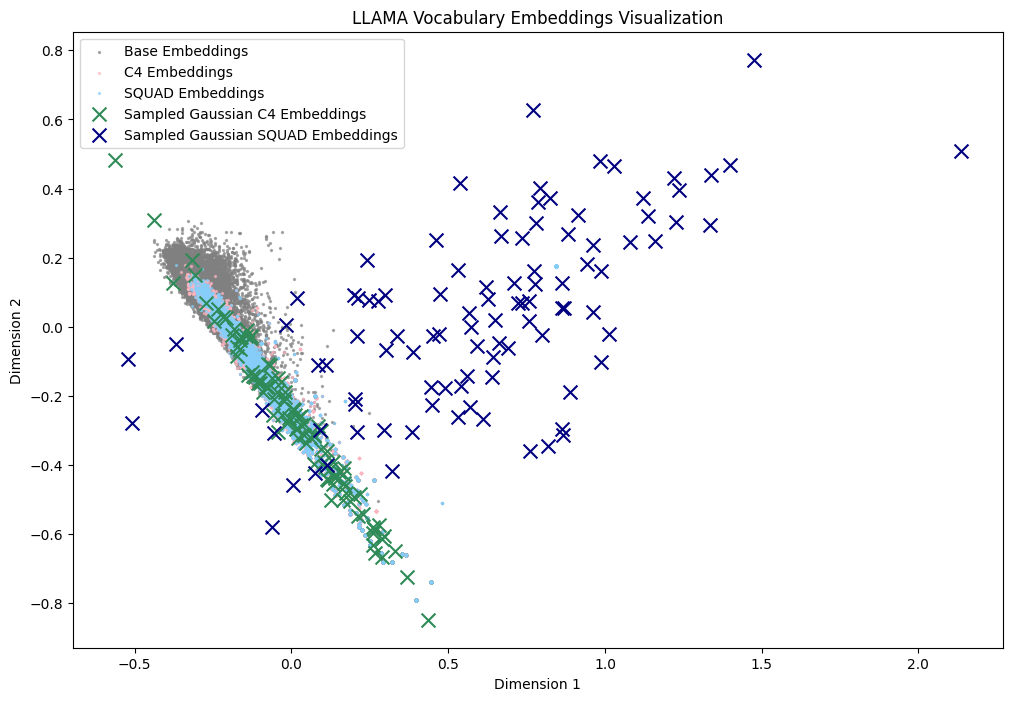

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 8))

n_embeds = embeddings.shape[0]
n_c4 = c4_embeddings.shape[0]
n_squad = squad_embeddings.shape[0]
plt.scatter(
    reduced_embeddings[:n_embeds, 0],
    reduced_embeddings[:n_embeds, 1],
    s=2, alpha=0.6, color='gray', label='Base Embeddings'
)
plt.scatter(
    reduced_embeddings[n_embeds:n_embeds+n_c4, 0],
    reduced_embeddings[n_embeds:n_embeds+n_c4, 1],
    s=2, alpha=0.6, color='lightpink', label='C4 Embeddings'
)
plt.scatter(
    reduced_embeddings[n_embeds+n_c4:n_embeds+n_c4+n_squad, 0],
    reduced_embeddings[n_embeds+n_c4:n_embeds+n_c4+n_squad, 1],
    s=2, alpha=0.6, color='lightskyblue', label='SQUAD Embeddings'
)
plt.scatter(
    reduced_embeddings[n_embeds+n_c4+n_squad:-100, 0],
    reduced_embeddings[n_embeds+n_c4+n_squad:-100, 1],
    s=100, alpha=1.0, color='seagreen', marker='x', label='Sampled Gaussian C4 Embeddings'
)
plt.scatter(
    reduced_embeddings[-100:, 0],
    reduced_embeddings[-100:, 1],
    s=100, alpha=1.0, color='navy', marker='x', label='Sampled Gaussian SQUAD Embeddings'
)

WRONG GAUSSIAN -- BECAUSE OF PADDINGS ??


plt.title("LLAMA Vocabulary Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

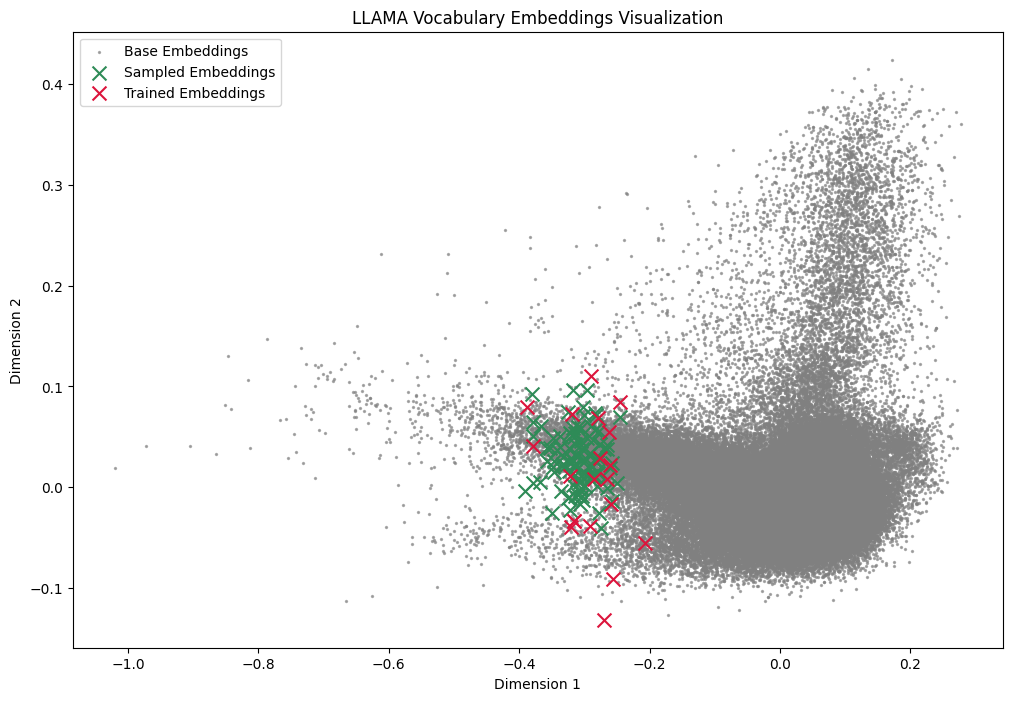

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 8))

# sns.kdeplot(
#     x=reduced_embeddings[:50000, 0],
#     y=reduced_embeddings[:50000, 1],
#     fill=True,  # Filled density
#     cmap="viridis",  # Colormap for the density
#     alpha=0.7,
#     levels=20,
#     bw_adjust=1.5
# )

n_embeds = embeddings.shape[0]
plt.scatter(
    reduced_embeddings[:n_embeds, 0],
    reduced_embeddings[:n_embeds, 1],
    s=2, alpha=0.6, color='gray', label='Base Embeddings'
)
plt.scatter(
    reduced_random_embeddings[:, 0],
    reduced_random_embeddings[:, 1],
    s=100, alpha=1.0, color='seagreen', marker='x', label='Sampled Embeddings'
)
plt.scatter(
    reduced_embeddings[n_embeds:, 0],
    reduced_embeddings[n_embeds:, 1],
    s=100, alpha=1.0, color='crimson', marker='x', label='Trained Embeddings'
)

plt.title("LLAMA Vocabulary Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [ ]:
model.base_model.forward

<bound method LlamaForCausalLM.forward of LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (lm_head): Linear(in_features=2048, out_features=128256, bias=False)
)>

In [ ]:
for layer in model.base_model.model.layers:
    print(layer.forward)
    break

In [ ]:
model.base_model.config._attn_implementation

In [ ]:
type(batch['attention_mask'])

In [ ]:
!pip install torchviz

In [ ]:
optimizer.zero_grad()

In [ ]:
from torchviz import make_dot
import torch

# inputs = torch.randn(4, 256, 2048, requires_grad=True)

# Forward pass
# batch['input_ids'].requires_grad = True
outputs = model(batch)

# Plot the computational graph
dot = make_dot(outputs.logits, params=dict(model.named_parameters()))
dot.render("model_graph", format="png")  # Save as a PNG file

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.853196 to fit


'model_graph.png'

In [ ]:
layer_name = f"deep-prompt-embeddings-layer-{0}"
model.virtual_token_parameters[layer_name]

Parameter containing:
tensor([[-0.1688,  0.1446, -0.1827,  ..., -0.4202, -0.4555,  0.5796],
        [-0.6592,  0.6233,  0.0561,  ...,  0.6937, -0.6044, -0.4631],
        [ 0.4100,  0.0488, -0.4044,  ..., -0.1257,  0.0583,  0.2804],
        ...,
        [-0.5827, -0.6114, -0.4117,  ..., -0.2283,  0.7608,  0.1834],
        [-0.1123, -0.3717,  0.0990,  ...,  0.2285,  0.3484, -0.5562],
        [ 0.5710, -0.5605,  0.6303,  ..., -0.4481, -0.0232,  0.7060]],
       device='cuda:0', requires_grad=True)

In [ ]:
outputs.loss.backward()

In [ ]:
model.virtual_token_parameters[layer_name].grad.norm()

tensor(0., device='cuda:0')

In [ ]:
optimizer.step()

In [ ]:
layer_name = f"deep-prompt-embeddings-layer-{0}"
model.virtual_token_parameters[layer_name]

Parameter containing:
tensor([[ 0.0150,  0.0464, -0.0137,  ..., -0.0879, -0.0038,  0.0491],
        [ 0.0071, -0.1001,  0.0243,  ..., -0.0287, -0.0566,  0.0173],
        [ 0.0256,  0.0347,  0.0045,  ...,  0.0234, -0.0498,  0.0517],
        ...,
        [-0.0437,  0.0402,  0.0015,  ...,  0.0017,  0.0492,  0.0095],
        [-0.0202,  0.0073,  0.0237,  ...,  0.0058, -0.0135,  0.0295],
        [ 0.0047,  0.0143,  0.0645,  ...,  0.0613, -0.0182,  0.0869]],
       device='cuda:0', requires_grad=True)

In [ ]:

attention_mask = batch['attention_mask']
extended_attention_mask = model.add_virtual_attention_mask(batch['attention_mask'])
attention_mask = attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=torch.bool)
extended_attention_mask = extended_attention_mask.unsqueeze(1).unsqueeze(2).to(dtype=torch.bool)

position_ids = torch.arange(
    0, 276,
    dtype=torch.long,
    device=model.device
).unsqueeze(0).repeat(2, 1)

# Prepare causal mask for attention
batch_size, seq_length = 2, 276
causal_mask = torch.zeros(
    (batch_size, 1, seq_length, seq_length),
    dtype=torch.bool,
    device=model.device
)
causal_mask = torch.triu(torch.ones_like(causal_mask[0], dtype=torch.bool), diagonal=1)
# Expand the causal mask to match batch size
causal_mask = causal_mask.unsqueeze(0).expand(batch_size, 1, seq_length, seq_length)

causal_mask = ~causal_mask
causal_mask[:, :, :, :20] = False


# print(f'layer_idx: {layer_idx}')
# print(f'causal_mask.shape before extended_attention_mask: {causal_mask.shape}')

# Combine causal mask with the existing attention mask
# if layer_idx in self.selected_layers:
# causal_mask = causal_mask | (~extended_attention_mask)

In [ ]:
import torch

# Parameters
batch_size = 2
seq_length = 276
num_virtual_tokens = 20  # First 20 tokens that all target tokens can attend to
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize base attention mask
attention_mask = torch.ones((batch_size, seq_length), device=device)

# Prepare causal mask for attention
causal_mask = torch.zeros((seq_length, seq_length), dtype=torch.bool, device=device)
causal_mask = torch.triu(torch.ones_like(causal_mask), diagonal=1)  # Standard causal mask

# Allow all tokens to attend to the first `num_virtual_tokens`
causal_mask[:, :num_virtual_tokens] = False

# Expand causal mask to include batch and head dimensions
causal_mask = causal_mask.unsqueeze(0).unsqueeze(0).expand(batch_size, 1, seq_length, seq_length)

# Incorporate the extended attention mask (for virtual tokens)
extended_attention_mask = torch.ones_like(attention_mask, dtype=torch.bool)
extended_attention_mask[:, num_virtual_tokens:] = attention_mask[:, num_virtual_tokens:]  # Restrict based on attention_mask
extended_attention_mask = extended_attention_mask.unsqueeze(1).unsqueeze(2).expand(batch_size, 1, seq_length, seq_length)

# Combine causal mask with extended attention mask
final_attention_mask = causal_mask | (~extended_attention_mask)

# Verify the result
print("Final Attention Mask Shape:", final_attention_mask.shape)


Final Attention Mask Shape: torch.Size([2, 1, 276, 276])


In [ ]:
causal_mask = torch.tril(torch.ones(2, 1, 276, 276, device='cuda'))
causal_mask[:, :, :20, :] = False

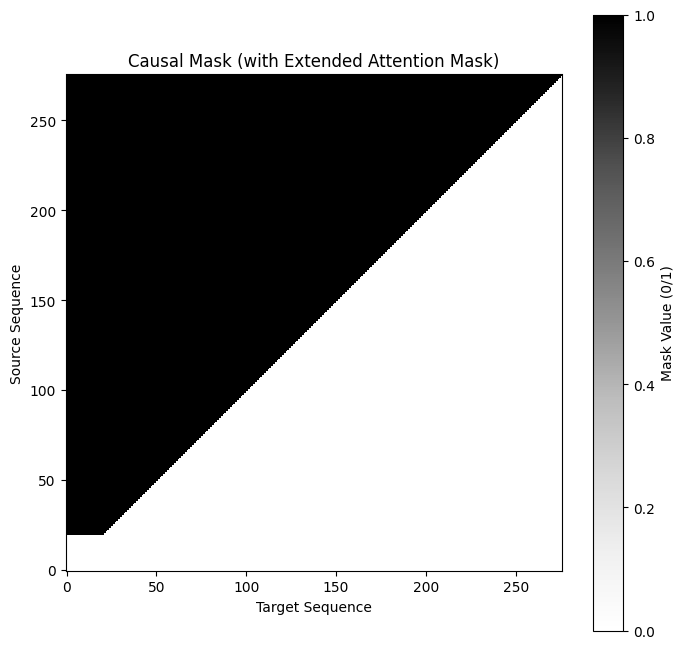

In [ ]:
import matplotlib.pyplot as plt

def plot_mask(mask, title):
    # Plot the first sample in the batch
    plt.figure(figsize=(8, 8))
    plt.imshow(mask[0, 0].cpu(), cmap='Greys', interpolation='nearest', origin='lower')
    plt.title(title)
    plt.xlabel("Target Sequence")
    plt.ylabel("Source Sequence")
    plt.colorbar(label="Mask Value (0/1)")
    plt.show()

# Plot the masks
plot_mask(causal_mask, "Causal Mask (with Extended Attention Mask)")

In [ ]:
causal_mask[0, 0, -1]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

tensor([[[ 0.0028,  0.0033, -0.0099,  ..., -0.0018,  0.0008,  0.0007],
         [-0.0109, -0.0254, -0.0175,  ...,  0.0260, -0.0129,  0.0103],
         [ 0.0035,  0.0170,  0.0623,  ..., -0.0334, -0.0315, -0.0074],
         ...,
         [-0.0027, -0.0043, -0.0092,  ..., -0.0121,  0.0281, -0.0515],
         [-0.0027, -0.0043, -0.0092,  ..., -0.0121,  0.0281, -0.0515],
         [-0.0027, -0.0043, -0.0092,  ..., -0.0121,  0.0281, -0.0515]],

        [[ 0.0028,  0.0033, -0.0099,  ..., -0.0018,  0.0008,  0.0007],
         [ 0.0121,  0.0009,  0.0139,  ..., -0.0193, -0.0179, -0.0464],
         [ 0.0087,  0.0148,  0.0613,  ..., -0.0251, -0.0231,  0.0093],
         ...,
         [ 0.0157,  0.0081,  0.0303,  ..., -0.0231, -0.0221, -0.0312],
         [-0.0022, -0.0160,  0.0078,  ...,  0.0043,  0.0198,  0.0171],
         [-0.0155, -0.0004,  0.0325,  ..., -0.0041,  0.0248, -0.0031]]],
       device='cuda:0')

In [ ]:
model

DeepPromptTunedModel(
  (base_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 2048)
      (layers): ModuleList(
        (0-15): 16 x LlamaDecoderLayer(
          (self_attn): LlamaSdpaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=512, bias=False)
            (v_proj): Linear(in_features=2048, out_features=512, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (rotary_emb): LlamaRotaryEmbedding()
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
          (post_atte

In [ ]:
model.virtual_token_parameters[0].device

In [ ]:
model.device

'cuda'

In [ ]:
model.virtual_token_parameters.keys()

dict_keys(['deep-prompt-embeddings-layer-0', 'deep-prompt-embeddings-layer-1', 'deep-prompt-embeddings-layer-11', 'deep-prompt-embeddings-layer-16', 'deep-prompt-embeddings-layer-6'])

In [ ]:
layer_name = f"deep-prompt-embeddings-layer-{0}"
model.virtual_token_parameters[layer_name]

Parameter containing:
tensor([[-0.0712,  0.0211, -0.0406,  ..., -0.0430,  0.0510,  0.0090],
        [-0.0205, -0.0328, -0.0449,  ..., -0.0082,  0.0152,  0.0331],
        [ 0.0326,  0.0110,  0.0212,  ..., -0.0070,  0.0415, -0.0201],
        ...,
        [ 0.0216, -0.0418, -0.0435,  ...,  0.0451, -0.0036,  0.0571],
        [-0.0378,  0.0229,  0.0411,  ..., -0.0547, -0.0263,  0.0453],
        [ 0.0389, -0.0654,  0.0384,  ..., -0.0323,  0.0024, -0.0620]],
       device='cuda:0', requires_grad=True)

In [ ]:
model.selected_layers

[0, 5, 10, 15]